# Endowment Economy

## Calibration with non homothetic demand

In [15]:
using NLsolve, Plots, Parameters, Distributions, ProgressMeter, Statistics, StatsPlots

@with_kw struct Calibration
    #Households
    σ::Float64=0.5                      # elasticity of relative demand with respect to price sigma=0.5 completementary goods
    γ::Array{Float64}=[1/3, 1/3, 1/3]   # intensity in each good
    ϵ::Array{Float64}=[0.8, 1.0, 1.5]  # elasticity of relative demand with respect to income in luxury good sector
    ρ::Float64 =(σ-1)/σ                 
end

cal = Calibration()

Calibration
  σ: Float64 0.5
  γ: Array{Float64}((3,)) [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
  ϵ: Array{Float64}((3,)) [0.8, 1.0, 1.5]
  ρ: Float64 -1.0


## How we solve for non homothetic utility. 
- Endowment translates into wealth since it can be sold on the market. 
- Utility maximization by solving for demand non linearities yield the non homothetic demand.

In [2]:
#NH Utility Function
function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    @unpack σ, γ, ϵ, ρ = cal

    E=sum(p[i]*C[i] for i=1:length(C))
    out=1-sum(γ[i]^(1/σ)*(((p[i]/E)^(-σ)*γ[i])/u^((1-σ)*σ*ϵ[i]))^ρ for i=1:length(C))
    return out
end

function NHUtility(C::Vector{Float64}, p::Vector{Float64} ;cal=cal)
    @unpack σ, γ, ϵ, ρ = cal

    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C endowment
    U=res.zero[1]

    #Wealth and Minimum expenditure for the utility at given endowment level
    E=sum(p[i]*C[i] for i=1:length(C))
    ExpNH=sum(γ[i]*U^(ϵ[i]*(1-σ)^2) * (p[i]^(1-σ)) for i = 1:length(C))^(1/(1-σ))
    
    #Optimal Demand with income effect
    C1=γ[1]*U^(ϵ[1]*(1-σ)^2)  * (p[1]/E)^(-σ)
    C2=γ[2]*U^(ϵ[2]*(1-σ)^2)  * (p[2]/E)^(-σ)
    C3=γ[3]*U^(ϵ[3]*(1-σ)^2)  * (p[3]/E)^(-σ)

    #Expenditure share with income effect
    ω_p=γ[1]*U^(ϵ[1]*(1-σ)^2)  * (p[1]/E)^(1-σ)
    ω_n=γ[2]*U^(ϵ[2]*(1-σ)^2)  * (p[2]/E)^(1-σ)
    ω_l=γ[3]*U^(ϵ[3]*(1-σ)^2)  * (p[3]/E)^(1-σ)

    #Optimal update for demand
    ω=[ω_p, ω_n, ω_l]
    W=ω_p+ω_n+ω_l

    return [C1, C2, C3, U, ω  , E, ExpNH]#, U, E, ω]

end

NHUtility (generic function with 1 method)

In [45]:
C1=[]
C2=[]
C3=[]
U=[]
E=[]
@showprogress for i=LinRange(1,12,30)
    for j=LinRange(1,12,30)
        for k=LinRange(1,12,30)
            res=NHUtility([i,j,k], [2.0, 3.0, 5.0])
            C1=push!(C1, res[1])
            C2=push!(C2, res[2])
            C3=push!(C3, res[3])
            U=push!(U, res[4])
            E=push!(E, res[7])
        end
    end
    sleep(0.001)
end

demand=[C1 C2 C3 U E]
demand=sortslices(demand,dims=1,by=x->(x[5]),rev=false)

X=demand[:,[1,2,3]]

Progress:   7%|██▊                                      |  ETA: 0:00:14

Progress:  10%|████▏                                    |  ETA: 0:00:13

Progress:  13%|█████▌                                   |  ETA: 0:00:13

Progress:  17%|██████▉                                  |  ETA: 0:00:13

Progress:  20%|████████▎                                |  ETA: 0:00:11

Progress:  23%|█████████▋                               |  ETA: 0:00:10

Progress:  27%|██████████▉                              |  ETA: 0:00:09

Progress:  30%|████████████▎                            |  ETA: 0:00:08

Progress:  33%|█████████████▋                           |  ETA: 0:00:07

Progress:  37%|███████████████                          |  ETA: 0:00:07

Progress:  40%|████████████████▍                        |  ETA: 0:00:06

Progress:  43%|█████████████████▊                       |  ETA: 0:00:06

Progress:  47%|███████████████████▏                     |  ETA: 0:00:05

Progress:  50%|████████████████████▌                    |  ETA: 0:00:05

Progress:  53%|█████████████████████▉                   |  ETA: 0:00:04

Progress:  57%|███████████████████████▎                 |  ETA: 0:00:04

Progress:  60%|████████████████████████▋                |  ETA: 0:00:04

Progress:  63%|██████████████████████████               |  ETA: 0:00:03

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:03

Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:02

Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:02

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:02

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:01

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:01

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:01

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:01

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


ErrorException: syntax: missing comma or ) in argument list

In [47]:
p1=plot(demand[:,5],X, 
title="Non Homothetic Demand for 3 different goods", 
xlabel="Endowment at market value",
ylabel="Quantity",
label=["Primary" "Normal" "Luxury"] ,
legend=:bottomright)

savefig(p1, "NHdemand.png") # save the most recent fig as filename_string (such as "output.png")


## Environment

In this example, prices were first given at p=[4.0, 5.0, 10.0].

However, this price level does not clear the market, we have demand that takes over endowment level in our economy. Hence we update the price level such that non homothetic is exactly equal to the endowment level.

We set 3 sectors with 300 agents.

### Random endowments

- Lognormal for luxury products
- Normal distribution for Primary and Normal, higher quantity for primary quantity

In terms of aggregate quantity : $ Q_P>Q_N>Q_L$

In [19]:
#Economy size
ng=3        #number of sector
na=1000   #number of people
p=[4.0, 5.0, 10.0]

#Good matrix
G=zeros(na,ng)

#Quantities distribution for each person
D_P=Normal(2,1)
D_P = truncated(D_P, 0.0, Inf)
D_N=Normal(1,1)
D_N = truncated(D_N, 0.0, Inf)
D_L=LogNormal(0.02,0.5)
D_L = truncated(D_L, 0.0, Inf)


qdist=plot(D_P, title="Quantities distribution", label="Primary")
plot!(D_N, label="Normal")
plot!(D_L, label="Luxury")

savefig(qdist, "q_dist.png")

12

34

56

78

910

1112

1314

1516

1718

1920

2122

2324

2526

2728

2930

3132

3334

3536

3738

3940

4142

4344

4546

4748

4950

5152

5354

5556

5758

5960

6162

6364

6566

6768

6970

7172

7374

7576

7778

7980

8182

8384

8586

8788

8990

9192

9394

9596

9798

99100

101102

103104

105106

107108

109110

111112

113114

115116

117118

119(W, D, Excess, p) = 

([2085.0578883437715, 1279.0134901657705, 1134.7193772823505], [2085.057880263482, 1279.0133905615453, 1134.7194194370823], [-8.080289717327105e-6, -9.960422516996914e-5, 4.215473177282547e-5], [1.3674840552214793, 4.6359401810132175, 10.895959210753423])


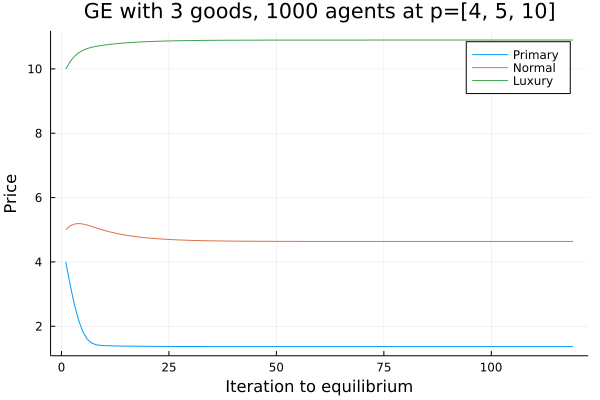

In [26]:
#Initial price level given
p=[4.0, 5.0, 10.0]

#leading to a Expenditure vector evaluated by a distribution of good
Exp=[]

for j=1:na
    G[j,1]=rand(D_P)
    G[j,2]=rand(D_N)
    G[j,3]=rand(D_L)
end

#Vectors and matrixes to store
W=zeros(ng)             #Endowment
D=zeros(ng)             #NH Demand
Excess=zeros(ng)
pricepath=[]

#iterations
tol=1e-4
iter=0
maxiter=400
step=0.001

#We are looking for a pricepath at the GE.
#First value for excess, 
#1. if D>W Price increases
#2. if D<W Price drops
for i=1:ng
    W[i]=sum(G[j,i] for j=1:na)
    D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)
end

Excess=D-W

for j =1:ng
    while iter<=maxiter && abs(Excess[j])>tol
        iter = iter + 1
        print(iter)
        pricepath=push!(pricepath, [p[1] p[2] p[3]])
        for i=1:ng
            p[i]=p[i]+step*Excess[i]
            W[i]=sum(G[j,i] for j=1:na)
            D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)        
        end
        Excess=D-W
    end
end

@show W,D, Excess, p

pricep=pricepath
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

p2=plot([p_p p_n p_l], title="GE with $ng goods, $na agents at p=[4, 5, 10]", label=["Primary" "Normal" "Luxury"], xlabel="Iteration to equilibrium", ylabel="Price")
savefig(p2, "endowge_before.png") # save the most recent fig as filename_string (such as "output.png")
p2


Suppose we know design a supply shock where a fifth of the Primary good aggregate quantity destroyed.

In [27]:
initial_p=p
Exp=[]
for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    Exp=push!(Exp,E)
end

initial=[G Exp]
initial=sortslices(initial,dims=1,by=x->(x[4]),rev=false)
G=convert(Matrix{Float64},initial[:,[1,2,3]])

#after shock endowment level
n_G=copy(G)
s_shock=1/5
n_G[:,1]=G[:,1].*(1-s_shock)
n_G

1000×3 Matrix{Float64}:
 0.687873  0.110381    0.438177
 0.656931  0.350511    0.400804
 0.459248  0.394413    0.442296
 1.15642   0.066221    0.480488
 0.561524  0.870928    0.234394
 1.95943   0.00384709  0.386875
 1.39638   0.0530007   0.478286
 1.19088   0.504791    0.323106
 0.533437  0.0292798   0.636979
 0.374069  0.347742    0.539261
 ⋮                     
 2.2583    2.89078     2.64423
 3.12415   0.869492    3.47183
 1.89987   0.916941    3.78023
 2.15692   1.82122     3.38006
 1.41641   0.627566    4.09713
 3.71109   2.66158     2.9586
 1.88409   0.036534    5.01957
 2.87173   1.47188     4.38637
 1.85892   1.35143     5.08589

Then continue to look for equilibrium at GE prices to find another GE with supply shock.

(W, D, Excess) = ([1668.0463106750153, 1279.013490165771, 1134.7193772823491], [1668.0463248773692, 1279.013583415872, 1134.719332933203], [1.4202353895598208e-5, 9.325010114480392e-5, -4.4349146037347964e-5])


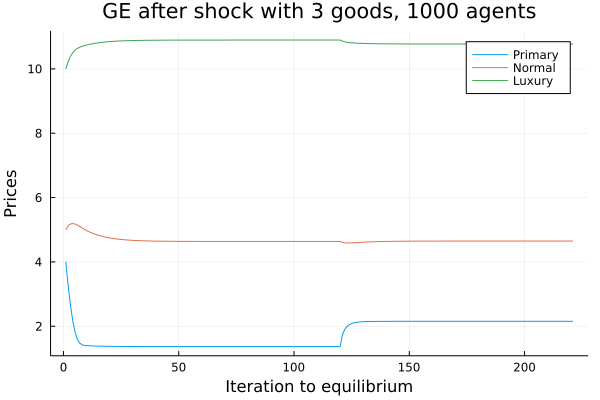

In [28]:
shockpricepath=pricepath
initial_p=[p[1], p[2], p[3]]

#After shock initial excess
for i=1:ng
    W[i]=sum(n_G[j,i] for j=1:na)
    D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)
end

Excess=D-W

iter_shock=0

for j =1:ng
    while iter_shock<=maxiter && abs(Excess[j])>tol
        iter_shock = iter_shock + 1
        shockpricepath=push!(shockpricepath, [p[1], p[2], p[3]])
        for i=1:ng
            p[i]=p[i]+0.001*Excess[i]
            W[i]=sum(n_G[j,i] for j=1:na)
            D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)        
        end
    Excess=D-W
    end
end

after_shock_p=p
pricep=shockpricepath

p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

@show W,D, Excess
pge=plot([p_p p_n p_l], title="GE after shock with $ng goods, $na agents", label=["Primary" "Normal" "Luxury"], xlabel="Iteration to equilibrium", ylabel="Prices")
savefig(pge, "ge_prices.png") # save the most recent fig as filename_string (such as "output.png")

pge

In [29]:
initial_p, after_shock_p

([1.3674840552214793, 4.6359401810132175, 10.895959210753423], [2.1543983346965994, 4.648479273001682, 10.773671980302675])

In [15]:
A=[]
B=[]

Exp=[]
C_P=[]
C_N=[]
C_L=[]
U=[]
#Deciles
for j=1:10
    for i=1:na/10
        A=push!(A,Int(i))
        B=push!(B,Int(j))
    end
end

#Initial endowment with GE prices

for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    C1=NHUtility(G[a,:],initial_p)[1]
    C2=NHUtility(G[a,:],initial_p)[2]
    C3=NHUtility(G[a,:],initial_p)[3]
    Utility=NHUtility(G[a,:],initial_p)[4]

    
    Exp=push!(Exp,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
#initial=sortslices(initial,dims=1,by=x->(x[1]),rev=false)

initial= [A U G Exp C_P C_N C_L]

1000×9 Matrix{Any}:
   1    0.382277  1.03311    0.000595761  …   0.420496   0.176943   0.121479
   2    0.415391  0.0232908  0.0161585        0.436436   0.185183   0.128864
   3    0.42207   0.57391    0.152603         0.439569   0.18681    0.130334
   4    0.839594  1.43357    0.0158064        0.599894   0.273096   0.213064
   5    0.8635    0.637817   0.506453         0.607622   0.277392   0.217405
   6    0.936671  1.7495     0.250751     …   0.630608   0.290237   0.230498
   7    1.03261   0.985377   0.288918         0.659374   0.30645    0.247261
   8    1.27201   0.823083   0.390673         0.72561    0.344339   0.287408
   9    1.28482   1.46275    0.298697         0.728962   0.346276   0.289496
  10    1.29765   0.196977   0.816507         0.732305   0.34821    0.291583
   ⋮                                      ⋱                        
  92  111.413     0.59525    1.25661          6.27147    4.65475    8.03631
  93  143.379     1.83641    2.30812          7.12068    5.42006  

In [16]:
#After the shock, endowment with GE prices
C_P=[]
C_N=[]
C_L=[]
U=[]
Exp_ng=[]
for a = 1:Int(length(n_G)/ng)
    E=sum(initial_p[i]*n_G[a,i] for i = 1:ng)
    C1=NHUtility(n_G[a,:],initial_p)[1]
    C2=NHUtility(n_G[a,:],initial_p)[2]
    C3=NHUtility(n_G[a,:],initial_p)[3]
    Utility=NHUtility(n_G[a,:],initial_p)[4]

    Exp_ng=push!(Exp_ng,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
after_shock=[A U n_G Exp_ng C_P C_N C_L]

1000×9 Matrix{Any}:
   1    0.321669  0.826488   0.000595761  …   0.389303   0.161014   0.107485
   2    0.413938  0.0186326  0.0161585        0.435752   0.184827   0.128544
   3    0.386613  0.459128   0.152603         0.422624   0.178039   0.122456
   4    0.727123  1.14686    0.0158064        0.561892   0.252143   0.192173
   5    0.812234  0.510253   0.506453         0.590907   0.268115   0.208054
   6    0.794492  1.3996     0.250751     …   0.584994   0.264847   0.204782
   7    0.948597  0.788302   0.288918         0.634265   0.292289   0.232606
   8    1.19625   0.658466   0.390673         0.705406   0.332702   0.274938
   9    1.15081   1.1702     0.298697         0.692971   0.325574   0.267359
  10    1.27925   0.157581   0.816507         0.727505   0.345434   0.288588
   ⋮                                      ⋱                        
  92  111.194     0.4762     1.25661          6.26528    4.64925    8.02425
  93  142.658     1.46913    2.30812          7.10258    5.40355  

In [17]:
loss=(initial-after_shock)./initial

1000×9 Matrix{Float64}:
 0.0  0.158544    0.2  0.0  0.0  0.0973023    …  0.0900259    0.115197
 0.0  0.0034969   0.2  0.0  0.0  0.00208769      0.00191885   0.00248684
 0.0  0.0840068   0.2  0.0  0.0  0.0509556       0.0469486    0.0604415
 0.0  0.133959    0.2  0.0  0.0  0.084           0.0767223    0.0980502
 0.0  0.05937     0.2  0.0  0.0  0.0367363       0.0334434    0.043009
 0.0  0.151792    0.2  0.0  0.0  0.0958646    …  0.08748      0.111568
 0.0  0.0813563   0.2  0.0  0.0  0.0508519       0.0462078    0.0592696
 0.0  0.0595638   0.2  0.0  0.0  0.0373398       0.033796     0.0433901
 0.0  0.104299    0.2  0.0  0.0  0.0659476       0.0597868    0.0764661
 0.0  0.0141838   0.2  0.0  0.0  0.00882604      0.007972     0.0102722
 ⋮                               ⋮            ⋱               
 0.0  0.00196159  0.2  0.0  0.0  0.00138302      0.00118217   0.00150081
 0.0  0.00503257  0.2  0.0  0.0  0.00356994      0.00304484   0.00386187
 0.0  0.00464236  0.2  0.0  0.0  0.0032967       

In [18]:
Utility_loss=loss[:,2]
p1=plot(Utility_loss, title="Loss for each individual rank from poorest to richest")
savefig(p1, "Utility_loss.png") # save the most recent fig as filename_string (such as "output.png")
p1

1000-element Vector{Float64}:
 0.15854379643054492
 0.003496902687484813
 0.08400679062810061
 0.13395895591544504
 0.059369976045112766
 0.15179156682019848
 0.0813562830879253
 0.059563760984502674
 0.10429925380493271
 0.01418378024747422
 ⋮
 0.001961588738788267
 0.005032572461574764
 0.004642361010707228
 0.0036495754513126673
 0.0035816149823676025
 0.0012160905037911444
 0.003563471318087546
 0.0036915844562465908
 0.0030596170642107497

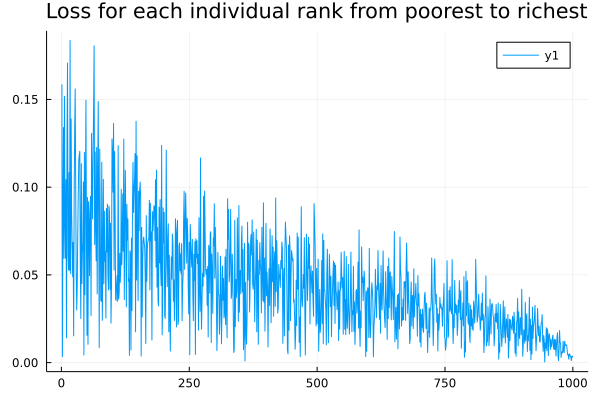

In [19]:
p1=plot(Utility_loss, title="Loss for each individual rank from poorest to richest")
savefig(p1, "Utility_loss.png") # save the most recent fig as filename_string (such as "output.png")
p1

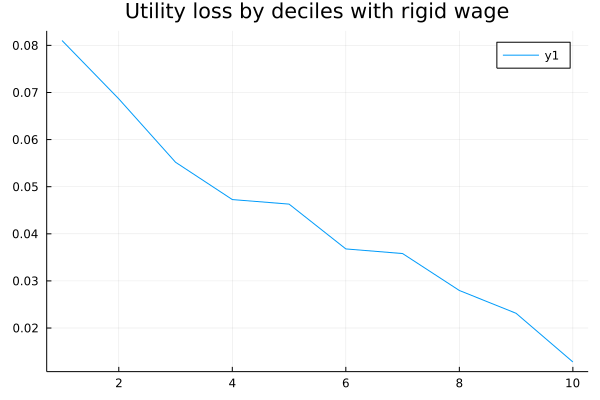

In [20]:
na_n=Int(na/10)
decile=10
dec=reshape(Utility_loss,(na_n,decile))
dec=mean(dec,dims=1)
dec=transpose(dec)

p2=plot(dec, title="Utility loss by deciles with rigid wage")
savefig(p2, "Utility_loss_deciles.png") # save the most recent fig as filename_string (such as "output.png")
p2